In [1]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

from numpy.linalg import norm

from utility_funcs import *

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

- В склерне оптимальные параметры ядра ищутся не градиентным спуском, а в gpytorch градиентным спуском как внутри pytorch - в этом главное отличие 

- Лосс, который пишется у гпр - это -log likelyhood loss для параметров, которые мы обучаем

- Мы добавляем какие-то параметры, чтобы не делать операции $O(N^3)$, а сделать несколько шагов оптимизации параметров вместе того, чтобы полностью точно считать обратную к K

- в склерне дефолтный кернел - это конст кернел * RBF - короче там 2 параметра обучается

In [ ]:
MODE

'movements'

In [ ]:
def make_predictions_and_check_quality(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    Качество

    '''

    if data:
        X_matrices, Y_target, *_ = list(map(lambda x: torch.stack(x), list(zip(*data))))

        
    Y_pred = model.predict(X_matrices)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = mean_squared_error(Y_pred, Y_target)

    print(metric)

    return Ys

In [ ]:
def formate_data_for_sklearn(data, size_cut=1):

    X = [elem[0].detach().numpy() for elem in data[:len(data) * size_cut]]
    Y = [elem[1].detach().numpy() for elem in data[:len(data) * size_cut]]

    X = np.stack(X)
    Y = np.stack(Y)
    return X, Y

In [ ]:
my_kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")  # пока фиксированные параметры

# my_kernel = ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) * RBF(1., length_scale_bounds=(1e-5, 1e5))

my_kernel

1**2 * RBF(length_scale=1)

In [ ]:
data = torch.load(path)

In [ ]:
train_data, val_data, *_ = recieve_loaders(
    path=path,
    # take_one_projection_for_data=0,

    # normalize_X=True,
    # scale_y=True
)       # in sklearn it is not learning in batches, so batch_size is not needed here

In [ ]:
train_X, train_Y = formate_data_for_sklearn(train_data)
val_X, val_Y = formate_data_for_sklearn(val_data)

In [ ]:
# normer = Normalizer()
# train_X = normer.fit_transform(train_X)
# val_X = normer.transform(val_X)

n_restarts_optimizer - если вдруг может быть несколько оптимумов чтобы несколько раз запустилось и попрбовало найти типо их несколько раз

- Что вообще оптимизируется - поскольку единственная случайно выбранная нами здесь вещь - это функция ядра, то мы как раз и оптимизируем параметры внутри этой функции ядра так, чтобы
мы получали ответы максимально близкие к таргетам. Она оптммизируется путем максимизации минус логарифма правдоподобия для данного параметра при условии данных

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import catboost

In [ ]:
model = GaussianProcessRegressor(
    kernel=my_kernel,
    random_state=0,
    n_restarts_optimizer=1,
    # normalize_y=True
    )

model.fit(train_X, train_Y)

Y_pred = model.predict(val_X, return_std=False)

In [ ]:
# model = catboost.CatBoostRegressor(loss_function="MultiRMSE")
# model.fit(train_X, train_Y)
# Y_pred = model.predict(val_X)

In [ ]:
# model = RandomForestRegressor(n_jobs=-1)
# model.fit(train_X, train_Y)
# Y_pred = model.predict(val_X)

In [ ]:
mean_squared_error(val_Y, Y_pred)

4.07839193786093e-09

In [ ]:
model.score(val_X, val_Y)

0.9251114326697918

In [ ]:
%%time
try: 
    make_predictions_and_check_quality(model=model, data=val_data, same_axis=False)
except:
    pass
None

4.07839193786093e-09
CPU times: user 2.62 ms, sys: 995 µs, total: 3.62 ms
Wall time: 2.76 ms


---
Снизу попытки что-то визуализировать:

In [ ]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

In [ ]:
Y_pred = model.predict(val_X)

In [ ]:
# plot_2d_result(
#     x11_val,
#     y_true=Y_true if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_true],
#     y_pred=Y_pred if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_pred],
#     figsize=(20, 10)
# )

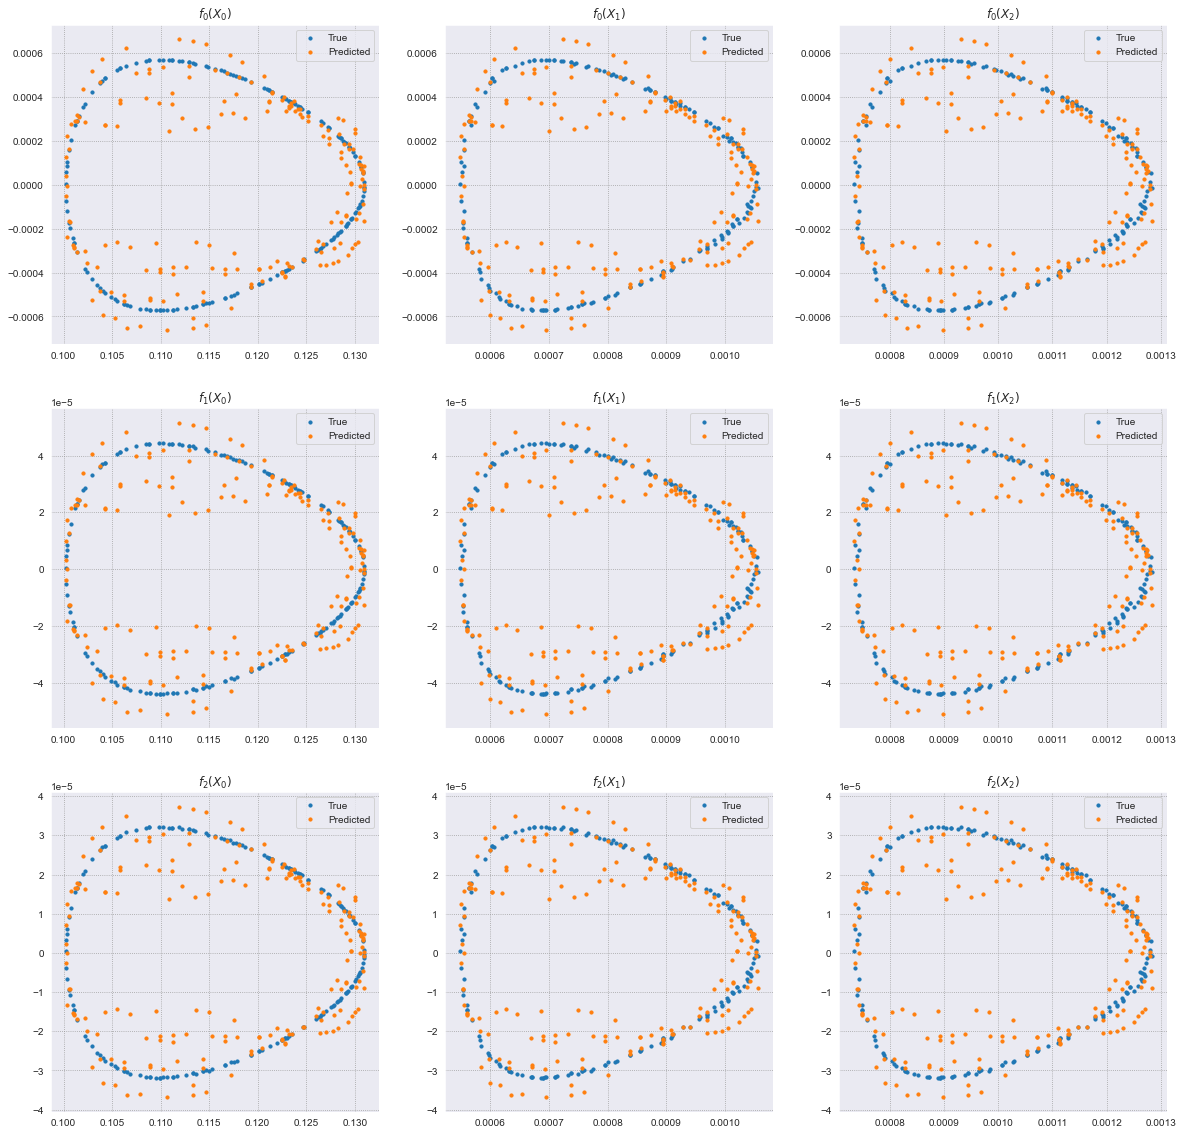

In [ ]:
if len(train_data[0][1]) != 1:
    plot_matrix(
        X=[elem[:-3] for elem in val_X] if MODE == "movements" else val_X,
        K=CFG.K,
        Y_true=val_Y,
        Y_pred=Y_pred,

        figsize=(20, 20)
    )

---
# Модель для скоростей:

In [ ]:
# path_vel = './dataset_objects/' + "d_velocities" + '/3_dataset_K_3.pt'        # ЗДЕСЬ БЫЛО МОДЕ ВМЕСТО movements

In [ ]:
data_vel = torch.load(path_vel)

In [ ]:
train_data_vel, val_data_vel, _, _, descaler = recieve_loaders(
    path=path_vel,
    # take_one_projection_for_data=0,

    # normalize_X=True,
    # scale_y=True
)       # in sklearn it is not learning in batches, so batch_size is not needed here

In [ ]:
train_X_vel, train_Y_vel = formate_data_for_sklearn(train_data_vel)
val_X_vel, val_Y_vel = formate_data_for_sklearn(val_data_vel)

In [ ]:
model_vel = GaussianProcessRegressor(
    kernel=my_kernel,
    random_state=0,
    n_restarts_optimizer=1,
    # normalize_y=True
    )

model_vel.fit(train_X_vel, train_Y_vel)

Y_pred_vel = model_vel.predict(val_X_vel, return_std=False)

In [ ]:
mean_squared_error(val_Y_vel, Y_pred_vel)

6.258614182292277e-11

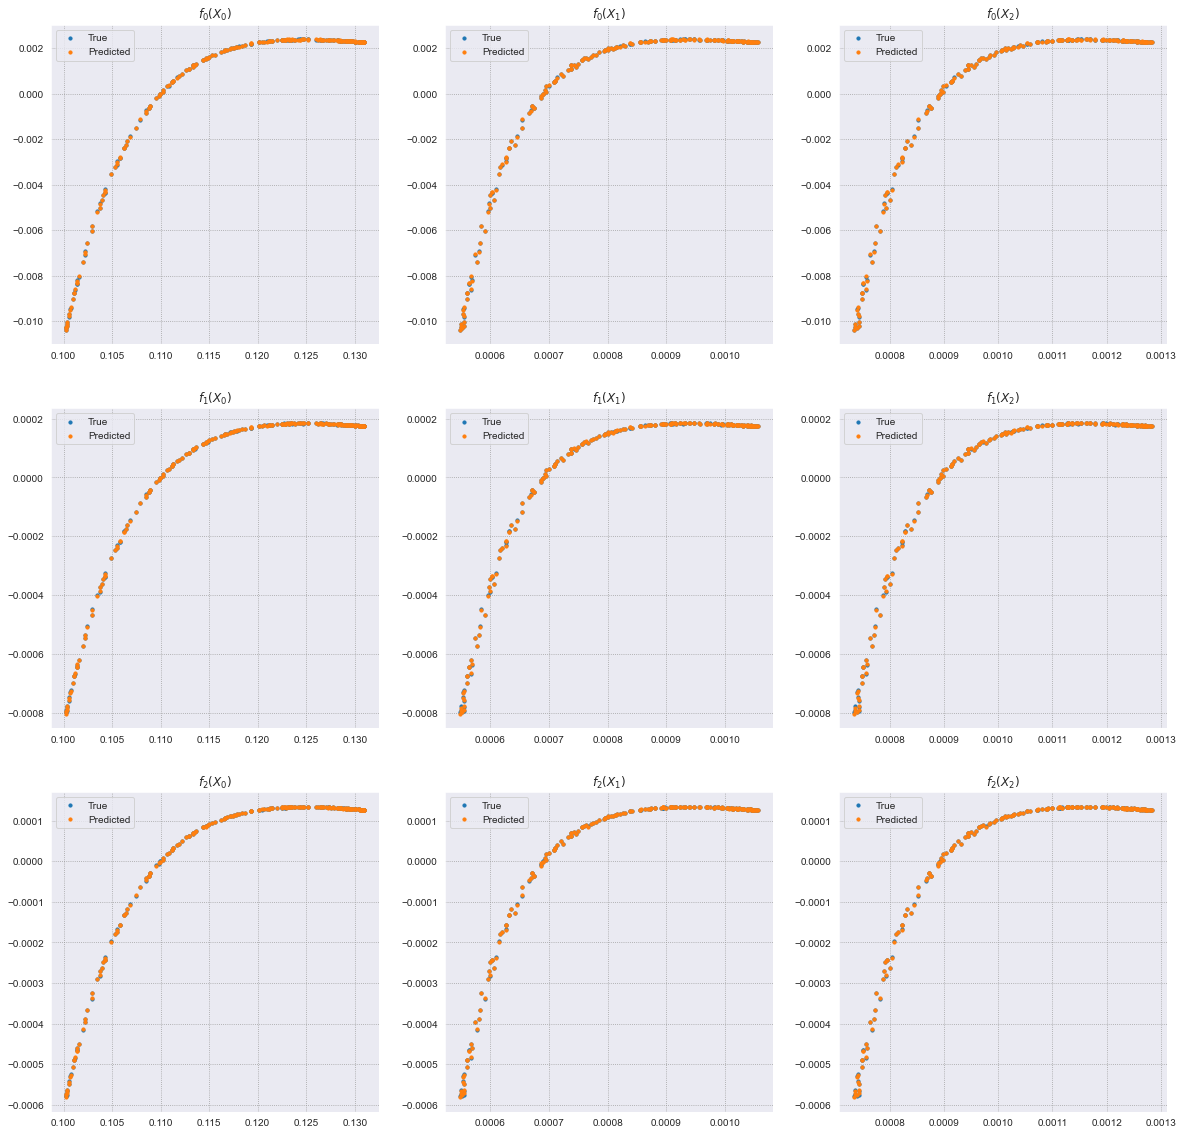

In [ ]:
if len(train_data[0][1]) != 1:
    plot_matrix(
        X=[elem[:-3] for elem in val_X_vel] if MODE == "movements" else val_X_vel,
        K=CFG.K,
        Y_true=val_Y_vel,
        Y_pred=Y_pred_vel,

        figsize=(20, 20)
    )

In [ ]:
import dill

In [ ]:
model_file_path = f'./trained_models/gpr_{CFG.N}_movements_K{CFG.K}.pickle'
model_vel_file_path = f'./trained_models/gpr_{CFG.N}_velocities_K{CFG.K}.pickle'

In [ ]:
pickle_mov = open(model_file_path, 'wb')
dill.dump(model, pickle_mov)
pickle_mov.close()

In [ ]:
pickle_vel = open(model_vel_file_path, 'wb')
dill.dump(model_vel, pickle_vel)
pickle_vel.close()

---
---
---

## Для реальных сил визуализация + сравнение с Верле:

Чтобы отрисовать Верле на том же графике надо взять проекцию $vdt + (F / 2 )dt^2$ в проекции на V_i

In [ ]:
t = val_data[0]

In [ ]:
Y_true_3d = [elem[3] for elem in val_data]

In [ ]:
Y_true_3d

[tensor([-2.2491e-04,  1.7487e-05,  1.2675e-05]),
 tensor([ 2.1263e-04, -1.6657e-05, -1.2073e-05]),
 tensor([-1.2304e-04,  9.3092e-06,  6.7474e-06]),
 tensor([ 4.9461e-04, -3.8007e-05, -2.7548e-05]),
 tensor([ 4.8273e-04, -3.6829e-05, -2.6694e-05]),
 tensor([-3.7847e-04,  2.9497e-05,  2.1379e-05]),
 tensor([-5.4426e-04,  4.1698e-05,  3.0223e-05]),
 tensor([-4.9191e-04,  3.7928e-05,  2.7490e-05]),
 tensor([ 4.7079e-04, -3.6642e-05, -2.6558e-05]),
 tensor([ 3.4483e-06, -5.0020e-07, -3.6255e-07]),
 tensor([ 7.2798e-05, -5.3742e-06, -3.8952e-06]),
 tensor([-2.9735e-04,  2.2610e-05,  1.6388e-05]),
 tensor([-2.9349e-04,  2.2775e-05,  1.6507e-05]),
 tensor([-1.5688e-04,  1.1839e-05,  8.5807e-06]),
 tensor([-5.2316e-04,  4.0416e-05,  2.9294e-05]),
 tensor([ 5.1219e-04, -3.9846e-05, -2.8881e-05]),
 tensor([-5.7079e-04,  4.3588e-05,  3.1593e-05]),
 tensor([ 5.6677e-04, -4.3918e-05, -3.1832e-05]),
 tensor([-2.4203e-04,  1.8479e-05,  1.3393e-05]),
 tensor([-2.5001e-04,  1.8980e-05,  1.3757e-05]),


In [ ]:
def s_by_verlet(X, dt):
    '''
    
    '''